# E0022 DIANN Generate Figures (Revision)

Checked by Rebecca Poulos on 16/03/2022.

##### Import packages

In [4]:
# !pip install adjustText
# !pip install fastcluster

In [39]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
from matplotlib.patches import Patch
import matplotlib.backends.backend_pdf
from matplotlib.patches import Patch
import fastcluster
from adjustText import adjust_text
import matplotlib.font_manager

In [40]:
import matplotlib.font_manager
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
# plt.rcParams['font.family'] = 'Arial'

##### Define colours

In [7]:
PALETTE_TTYPE = {
    "Lung": "#007fff",
    "Prostate": "#665d1e",
    "Stomach": "#ffbf00",
    "Central Nervous System": "#fbceb1",
    "Skin": "#ff033e",
    "Bladder": "#ab274f",
    "Hematopoietic and Lymphoid": "#d5e6f7",
    "Kidney": "#7cb9e8",
    "Thyroid": "#efdecd",
    "Soft Tissue": "#8db600",
    "Head and Neck": "#e9d66b",
    "Ovary": "#b284be",
    "Bone": "#b2beb5",
    "Endometrium": "#10b36f",
    "Breast": "#6e7f80",
    "Pancreas": "#ff7e00",
    "Peripheral Nervous System": "#87a96b",
    "Cervix": "#c9ffe5",
    "Large Intestine": "#9f2b68",
    "Liver": "#00ffff",
    "Vulva": "#008000",
    "Esophagus": "#cd9575",
    "Biliary Tract": "#72a0c1",
    "Other tissue": "#a32638",
    "Small Intestine": "#9966cc",
    "Placenta": "#f19cbb",
    "Testis": "#e32636",
    "Adrenal Gland": "#3b7a57",
    "Other": "whitesmoke"
}

##### Import datasets

In [8]:
df = pd.read_csv('matrix_diann_normalised_051021/e0022_diann_051021_working_matrix_averaged.txt', sep='\t').set_index('Project_Identifier')
df_frozen = pd.read_csv('matrix_diann_normalised_051021/e0022_diann_051021_frozen_matrix_averaged.txt', sep='\t').set_index('Project_Identifier')
df_sample_map = pd.read_csv('matrix_diann_normalised_051021/e0022_diann_051021_sample_mapping_replicates.txt', sep='\t').set_index('Automatic_MS_filename')
df_sample_map['Tissue_type'] = df_sample_map['Tissue_type'].str.replace('Haematopoietic','Hematopoietic')
df_map = pd.read_csv('matrix_diann_normalised_051021/e0022_diann_051021_sample_mapping_averaged.txt', sep='\t').set_index('Project_Identifier')
df_map['Tissue_type'] = df_map['Tissue_type'].str.replace('Haematopoietic','Hematopoietic')
print('Protein matrix shape:',df.shape)
print('Frozen protein matrix shape:',df_frozen.shape)
print('Master mapping file shape:', df_sample_map.shape)
print('Mapping file shape:',df_map.shape)

Protein matrix shape: (949, 6692)
Frozen protein matrix shape: (949, 8498)
Master mapping file shape: (6864, 12)
Mapping file shape: (949, 5)


In [9]:
prot_gene_df = pd.read_csv('matrix_diann_normalised_051021/uniprot-yourlist_M20211011A084FC58F6BBA219896F365D15F2EB442254481.tab', sep='\t')
print('Proteins in mapping:',len(prot_gene_df))
prot_gene_df = prot_gene_df.rename(columns={'Gene names  (primary )':'Gene'}).dropna()[lambda x: x['Entry name'].str.contains('_HUMAN')]
prot_gene_df['ID'] = prot_gene_df['Entry']+';'+prot_gene_df['Entry name']
prot_gene_dict = prot_gene_df.set_index('ID').to_dict()['Gene']
gene_prot_dict = prot_gene_df.set_index('Gene').to_dict()['ID']

Proteins in mapping: 8498


## Main paper figures

##### Get median proteins per cell line

In [10]:
print('Median proteins per cell line:',str(df_frozen.count(axis=1).median()))
print('Minimum proteins per cell line:',str(df_frozen.count(axis=1).min()))
print('Maximum proteins per cell line:',str(df_frozen.count(axis=1).max()))

Median proteins per cell line: 5237.0
Minimum proteins per cell line: 2523
Maximum proteins per cell line: 6251


##### Tissue-specific heatmap

Number of tissue-specific proteins: 279 



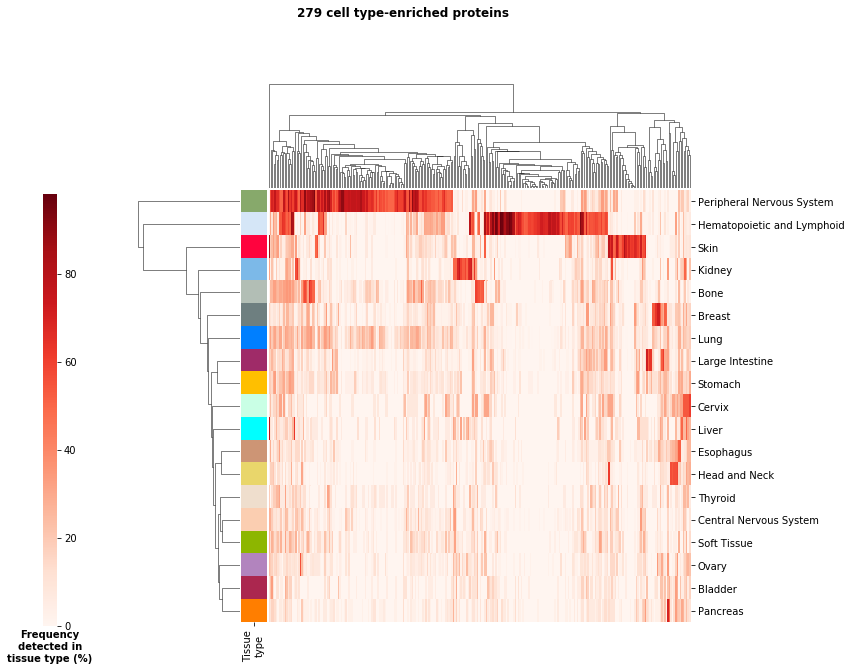

In [8]:
# Define limits for tissue-specific proteins
upper_limit = 50
lower_limit = 35

# Calculate cell lines per tissue 
tissue_counts = df_map.groupby('Tissue_type').count()
tissues_incl = tissue_counts[lambda x: x.Cell_line > 10].index.tolist()
tissue_counts = tissue_counts.to_dict()['Cell_line']

# Get % of each tissue where protein was identified
plot_df = df.copy()
plot_df = plot_df.join(df_map['Tissue_type']).groupby('Tissue_type').count().transpose()[tissues_incl]
for tissue in tissues_incl:
    plot_df[tissue] = plot_df[tissue]/tissue_counts[tissue]*100
plot_df = plot_df.transpose()

# Calculate tissue-specific proteins
tissue_spec_dict = {}
protein_list = []
for tissue in plot_df.index.tolist():
    tissue_spec_dict[tissue] = []
for protein in plot_df.columns.tolist():
    high_freq = len(plot_df[lambda x: x[protein] >= upper_limit].index.tolist())
    mid_freq = len(plot_df[lambda x: (x[protein] < upper_limit) & (x[protein] > lower_limit)].index.tolist())
    if high_freq == 1 or high_freq == 2:
        if mid_freq == 0:
            protein_list.append(protein)
            for n in plot_df[lambda x: x[protein] >= upper_limit].index.tolist():
                tissue_spec_dict[n].append(protein)
print('Number of tissue-specific proteins:',len(protein_list),'\n')

# Generate heatmap
heatmap_df = plot_df.reset_index().rename(columns={'Tissue_type':' '}).set_index(' ')[protein_list]
df_colours = pd.DataFrame.from_dict(PALETTE_TTYPE, orient='index').rename(columns={0:'Tissue\ntype'})
plot = sns.clustermap(heatmap_df, figsize=[10,10], row_cluster=True, col_cluster=True, xticklabels=False, yticklabels=True, row_colors=df_colours, cmap='Reds')
plot.fig.suptitle(str(len(protein_list))+' cell type-enriched proteins', weight='bold', ha='center')
plot.cax.set_position((0,0.12,0.02,0.6))
plt.xlabel('Frequency\ndetected in\ntissue type (%)', weight='bold')
plt.savefig('Revisions/tissue_specific_heatmap.pdf', dpi=500, bbox_inches='tight')
plt.savefig('Revisions/tissue_specific_heatmap.png', dpi=500, bbox_inches='tight')
plt.show()

##### Tissue-specific protein counts

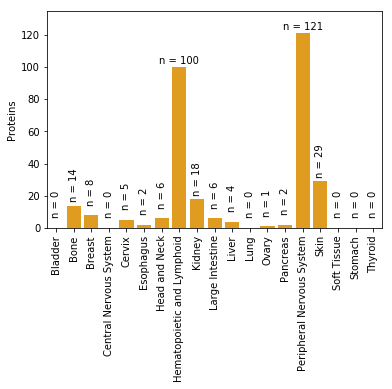

In [9]:
plot_df = pd.DataFrame(index=tissue_spec_dict)
for tissue in tissue_spec_dict:
    plot_df.loc[tissue,'Proteins'] = len(tissue_spec_dict[tissue])
plot = sns.barplot(x='index', y='Proteins', data=plot_df.reset_index(), color='orange')
plot.set_xlabel('')
plot.set_xticklabels(plot.get_xticklabels(), rotation=90)

# Generate labels
plot_df = plot_df.reset_index().reset_index().set_index('index')
plot_df['Proteins'] = plot_df['Proteins'].astype(int)
for tissue in plot_df.index.tolist():
    if plot_df.loc[tissue,'Proteins'] < 30:
        rot=90
        y_val=18
    else:
        rot=0
        y_val=2
    plot.text(plot_df.loc[tissue,'level_0'], plot_df.loc[tissue,'Proteins']+y_val, 'n = '+str(plot_df.loc[tissue,'Proteins']), rotation=rot, ha='center')

plot.set_ylim(0,135)
plt.savefig('Revisions/tissue_specific_bar_plot.pdf', dpi=500, bbox_inches='tight')
plt.savefig('Revisions/tissue_specific_bar_plot.png', dpi=500, bbox_inches='tight')
plt.show()

##### Generate input for GO term analysis

In [10]:
df_tissue_spec = pd.DataFrame()
num = 0
for tissue in tissue_spec_dict:
    for protein in tissue_spec_dict[tissue]:
        df_tissue_spec.loc[num,'Tissue'] = tissue
        df_tissue_spec.loc[num,'Protein'] = protein
        num += 1
df_tissue_spec.to_csv('Revisions/tissue_specific_protein_list.txt', sep='\t', index=False)

In [11]:
tissues_of_interest = ['Hematopoietic and Lymphoid','Peripheral Nervous System','Skin']
for tissue in tissues_of_interest:
    print('\n'+tissue+' ('+str(len(tissue_spec_dict[tissue]))+')\n')
    for x in tissue_spec_dict[tissue]:
        print(prot_gene_dict[x])
    pd.DataFrame(index=[prot_gene_dict[x] for x in tissue_spec_dict[tissue]]).reset_index().to_csv('Revisions/tissue_specific_proteins_'+tissue.replace(' ','_')+'.txt', sep='\t', index=False, header=False)


Hematopoietic and Lymphoid (100)

TCF3
PTPRCAP
TMA7
CELF2
HCLS1
ARID3A
F8A1; F8A2; F8A3
IKZF1
EVL
SEPTIN1
WAS
ITGAL
PTPRC
CHURC1
ARHGAP45
APBB1IP
IRAG2
TLK2
INPP5D
KCNAB2
ACAP1
NFKBIE
VAV1
FERMT3
REL
DOCK8
DTNBP1
RSRC2
IKBKB
GMIP
PLCG2
MYO1G
ITGB2
IL16
MYCBP2
ZWINT
ELMO1
NUB1
RCSD1
PIK3AP1
PLEKHA2
CRLF3
RASAL3
DEF6
PTPN7
LIMD2
IKBKG
EIF4ENIF1
PRKCB
RASSF2
ARHGEF6
HLA-DPB1
DOK3
FLI1
GLCCI1
MZB1
FGD3
RANGRF
NSL1
SLBP
ARHGAP25
ARHGAP4
PTK2B
ICAM3
IKZF3
CD48
CFAP298
CD38
CYFIP2
TTF2
DOCK2
LSP1
RABGAP1L
SPC25
SASH3
IRF4
CTDP1
NCKAP1L
SYK
TNFAIP8
CASP2
ASF1B
GMFG
RPUSD2
RNGTT
ASDURF
LAT2
RPS6KB1
CARMIL2
GNB1L
SPN
ANKRD44
BTK
ACYP2
ARHGAP30
IRAK4
MAP4K1
SH3BP1
CCNB2
ARHGAP15

Peripheral Nervous System (121)

TTC5
ATAT1
TCF3
TAGLN3
MAPT
NAPB
CPLX2
MPP2
DPYSL5
DICER1
F8A1; F8A2; F8A3
MAP2K6
GFRA2
SEPTIN5
CHGB
CEND1
SNAP25
PRPH
PSMC3IP
PCSK1N
GAP43
NACAD
TLK2
NEFM
CHD7
ZNF629
GPC2
DBH
DDC
CEP97
ATL1
SEPTIN3
SETMAR
RBP1
STMN2
GSE1
CRABP1
MYCBP2
FAM171A2
NEFL
KIF5C
SYNPO2
DCX
DCP1B
IGFBPL1
CUEDC2

##### Get RNA~protein correlations across tissue type

0.43530953628085306
0.812821733787106
0.3261393109565752
0.46531454725716903


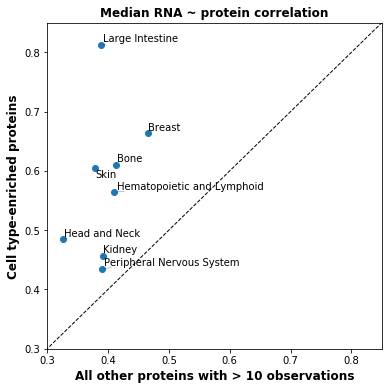

In [12]:
# Import RNA-seq data
df_rna = pd.read_csv('../files_e0022_cell_lines_diann_reanalysis/rnaseq_voom.csv.gz').rename(columns={'Unnamed: 0':'index'}).set_index('index')
df_rna = df_rna[[x for x in df_rna.columns.tolist() if x in df_map['SIDM'].unique().tolist()]]
df_rna = df_rna.rename(columns=df_map.reset_index().set_index('SIDM').to_dict()['Project_Identifier'])
df_rna = df_rna.transpose().rename(columns=gene_prot_dict)
df_rna = df_rna[[x for x in df_rna.columns.tolist() if x in df.columns.tolist()]]

# Calculate correlations
master_proteins = [x for x in df_rna.columns.tolist() if x in df.columns.tolist()]
master_corr_df = pd.DataFrame()
for tissue in tissues_incl:
    proteins = [x for x in tissue_spec_dict[tissue] if x in master_proteins]
    if len(proteins) > 5:
        cell_lines = [x for x in df_map[lambda x: x.Tissue_type == tissue].index.unique().tolist() if x in df_rna.index.tolist()]
        corr_df = pd.DataFrame()
        for protein in proteins:
            curr_df = df_rna.loc[cell_lines][[protein]].rename(columns={protein:'RNA'}).join(df.loc[cell_lines][[protein]].rename(columns={protein:'Protein'})).dropna()
            corr_df.loc[protein,'Corr'] = scipy.stats.pearsonr(curr_df['RNA'], curr_df['Protein'])[0]
        corr_df_other = pd.DataFrame()
        proteins_other = [x for x in master_proteins if x not in proteins]
        for protein in proteins_other:
            curr_df = df_rna.loc[cell_lines][[protein]].rename(columns={protein:'RNA'}).join(df.loc[cell_lines][[protein]].rename(columns={protein:'Protein'})).dropna()
            if len(curr_df) > 10:
                corr_df_other.loc[protein,'Corr'] = scipy.stats.pearsonr(curr_df['RNA'], curr_df['Protein'])[0]
        master_corr_df.loc[tissue,'Tissue_specific_corr'] = corr_df['Corr'].median()
        master_corr_df.loc[tissue,'Other_corr'] = corr_df_other['Corr'].median()
        
# Check axis limits
print(master_corr_df['Tissue_specific_corr'].min())
print(master_corr_df['Tissue_specific_corr'].max())
print(master_corr_df['Other_corr'].min())
print(master_corr_df['Other_corr'].max())

# Check no tissues missed by lack of matched data
for tissue in tissue_spec_dict:
    if len(tissue_spec_dict[tissue]) > 5:
        if tissue not in master_corr_df.index.tolist():
            print(tissue)

# Generate plot
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(master_corr_df['Other_corr'], master_corr_df['Tissue_specific_corr'])
ax.set_title('Median RNA ~ protein correlation', weight='bold', fontsize=12)
ax.set_xlabel('All other proteins with > 10 observations', weight='bold', fontsize=12)
ax.set_ylabel('Cell type-enriched proteins', weight='bold', fontsize=12)
ax.set_xlim(0.3,0.85) #checked
ax.set_ylim(0.3,0.85) #checked
ax.plot([0,1],[0,1], color='black', linewidth=1, linestyle='--')
labels = [ax.text(master_corr_df.loc[tissue,'Other_corr'], master_corr_df.loc[tissue,'Tissue_specific_corr'], tissue, size=10) for tissue in master_corr_df.index.tolist()]
adjust_text(labels, arrowprops=dict(arrowstyle='-', color='k', alpha=0.75, lw=0.3), ax=ax)
plt.savefig('Revisions/tissue_specific_rna_corr.pdf', dpi=500, bbox_inches='tight')
plt.savefig('Revisions/tissue_specific_rna_corr.png', dpi=500, bbox_inches='tight')
plt.show()

##### Compare RNA abundance of observed vs missing proteins

MannwhitneyuResult(statistic=14987485.5, pvalue=0.0)


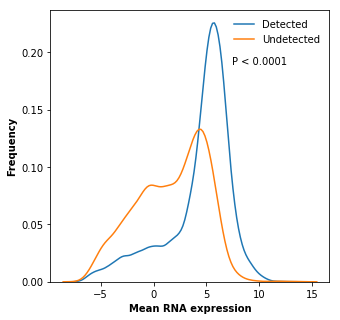

In [35]:
# Import RNA-seq data
df_rna = pd.read_csv('../files_e0022_cell_lines_diann_reanalysis/rnaseq_voom.csv.gz').rename(columns={'Unnamed: 0':'index'}).set_index('index')
df_rna = df_rna[[x for x in df_rna.columns.tolist() if x in df_map['SIDM'].unique().tolist()]]
df_rna = df_rna.rename(columns=df_map.reset_index().set_index('SIDM').to_dict()['Project_Identifier'])

# Define detected and undetected genes
detected_genes = [x for x in df_rna.index.tolist() if x in list(gene_prot_dict.keys())]
undetected_genes =[x for x in df_rna.index.tolist() if x not in list(gene_prot_dict.keys())]

# Compare means
detected_genes_mean = df_rna.loc[detected_genes].mean(axis=1)
undetected_genes_mean = df_rna.loc[undetected_genes].mean(axis=1)
print(scipy.stats.mannwhitneyu(undetected_genes_mean, detected_genes_mean))

# Generate plot
fig = plt.figure(figsize=[5,5])
plot = sns.distplot(detected_genes_mean, label='Detected', hist=False)
plot = sns.distplot(undetected_genes_mean, label='Undetected', hist=False)
plot.set_xlabel('Mean RNA expression', weight='bold')
plot.set_ylabel('Frequency', weight='bold')
plot.text(0.65,0.8, 'P < 0.0001', transform = plot.transAxes)
plt.legend(frameon=False)
plt.savefig('Revisions/distribution_mean_rna_exp.pdf', dpi=500, bbox_inches='tight')
plt.savefig('Revisions/distribution_mean_rna_exp.png', dpi=500, bbox_inches='tight')
plt.show()

## Response to Reviewers

##### Skin cell lines

In [15]:
df_map[lambda x: x.Tissue_type == 'Skin'].groupby('Cancer_type').count()[['Cell_line']]

,Cell_line
Cancer_type,
Melanoma,51
Other Solid Carcinomas,3


##### VCB data

Cell lines dataset: (949, 6345)
Tissue datasets: (1283, 6345)

Common tissue types: 15 



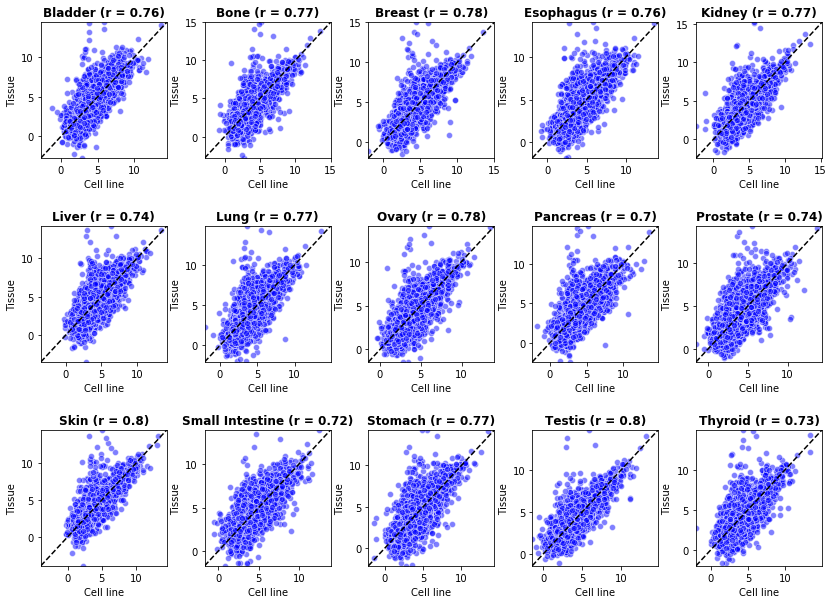

In [32]:
# Import VCB data
df_vcb = pd.read_csv('Revisions/filtered_protein_matrix_noHeks_noNonHuman_logged_normalized_merged_replicates.csv')
df_vcb_map = df_vcb.iloc[:,0:18].set_index('Run')
df_vcb_map['Tissue of origin category'] = df_vcb_map['Tissue of origin category'].str.replace('Oesophagus', 'Esophagus')
df_vcb = df_vcb.set_index('Run').iloc[:,17:]

# Rename cell line protein list
scl_dict = {}
for x in df.columns.tolist():
    scl_dict[x] = x.split(';')[0]
df_scl = df.rename(columns=scl_dict)

# Find common proteins
df_scl = df_scl[[x for x in df_scl.columns.tolist() if x in df_vcb.columns.tolist()]]
df_vcb = df_vcb[[x for x in df_vcb.columns.tolist() if x in df_scl.columns.tolist()]]
print('Cell lines dataset:',df_scl.shape)
print('Tissue datasets:',df_vcb.shape)

# Find common tissues
common_list = []
for x in df_vcb_map['Tissue of origin category'].unique().tolist():
    if x in df_map['Tissue_type'].unique().tolist():
        common_list.append(x)
common_list = sorted(common_list)
print('\nCommon tissue types:', len(common_list),'\n')

# Generate correlation plots
fig = plt.figure(figsize=[14,10])
num = 0
for tissue in common_list:
    num += 1
    samples_from_tissue_vcb = df_vcb_map[lambda x: (x['Tissue of origin category'] == tissue) & (x['Tissue Type'] == 'Tumour')].index.tolist()
    samples_from_tissue_scl = df_map[lambda x: x['Tissue_type'] == tissue].index.tolist()
    df_corr = df_scl.loc[samples_from_tissue_scl].mean().to_frame('Cell line').join(df_vcb.loc[samples_from_tissue_vcb].mean().to_frame('Tissue')).dropna()
    corr = round(scipy.stats.pearsonr(df_corr['Cell line'], df_corr['Tissue'])[0], 2)
    ax = fig.add_subplot(3,5,num)
    plot = sns.scatterplot(x='Cell line', y='Tissue', data=df_corr, color='blue', alpha=0.5)
    plot.set_title(tissue+' (r = '+str(corr)+')', weight='bold')
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, color='black', linestyle='--')
    plot.set_xlim(df_corr.min().min(), df_corr.max().max())
    plot.set_ylim(df_corr.min().min(), df_corr.max().max())
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.savefig('Revisions/revision_figure_tissue_vs_cell_corr.pdf', dpi=500, bbox_inches='tight')
plt.savefig('Revisions/revision_figure_tissue_vs_cell_corr.png', dpi=500, bbox_inches='tight')
plt.show()

In [29]:
print('Mean proteins per cell line (ProCan-DepMapSanger):',df_frozen.count(axis=1).mean())
vcb_tumour_samples = df_vcb_map[lambda x: x['Tissue Type'] == 'Tumour'].index.tolist()
print('Mean proteins per tissue (VCB):',df_vcb.loc[vcb_tumour_samples].count(axis=1).mean())
# VCB is 5174 with frozen matrix, per Simon's calc

Mean proteins per cell line (ProCan-DepMapSanger): 5208.492096944152
Mean proteins per tissue (VCB): 4417.768553459119


##### Cellular compartments

In [15]:
from scipy.stats import hypergeom
# pd.DataFrame(index=[x.split(';')[0] for x in df_frozen.columns.tolist() if '_HUMAN' in x]).reset_index().to_csv('Revisions/uniprot_8498.txt', sep='\t')

In [16]:
ncbi_to_uniprot_dict = pd.read_csv('Revisions/M2022031692C7BAECDB1C5C413EE0E0348724B68246208BV.tab', sep='\t').set_index('To').to_dict()['From']
print('NCBI to uniprot dictionary length:',len(ncbi_to_uniprot_dict))
gene2go = pd.read_csv('Revisions/gene2go', sep='\t')[lambda x: x['#tax_id'] == 9606]
gene2go['uniprot'] = gene2go['GeneID'].map(ncbi_to_uniprot_dict)
go_dict = gene2go[['GO_ID','GO_term']].drop_duplicates().set_index('GO_ID').to_dict()['GO_term']

GO_CC_list = gene2go[lambda x: x.Category == 'Component']['GO_ID'].unique().tolist()
df_go_cc = pd.DataFrame(columns=['GO_CC']).set_index('GO_CC')
for go_cc in GO_CC_list:
    
    # Define background
    M = len(gene2go['GeneID'].unique().tolist()) # M is the population size
    n = len(gene2go[lambda x: x.GO_ID == go_cc]['GeneID'].unique().tolist()) # n is the number of successes in the population
    
    # Significance of proteins found in the study
    N = len(gene2go[lambda x: ~x.uniprot.isna()]['GeneID'].unique().tolist()) # N is the sample size
    X = len(gene2go[lambda x: (~x.uniprot.isna()) & (x['GO_ID'] == go_cc)]['GeneID'].unique().tolist()) # X is  the number of drawn “successes”
    pval_in = hypergeom.sf(X-1, M, n, N)
    df_go_cc.loc[go_cc,'Perc_in_study'] = X/N
    
    # Significance of proteins not found in the study
    N = len(gene2go[lambda x: x.uniprot.isna()]['GeneID'].unique().tolist()) # N is the sample size
    X = len(gene2go[lambda x: (x.uniprot.isna()) & (x['GO_ID'] == go_cc)]['GeneID'].unique().tolist()) # X is  the number of drawn “successes”
    pval_out = hypergeom.sf(X-1, M, n, N)
    df_go_cc.loc[go_cc,'Perc_out_study'] = X/N
    
    # Write data out
    df_go_cc.loc[go_cc,'GO_term'] = go_dict[go_cc]
    df_go_cc.loc[go_cc,'GO_size'] = n
    df_go_cc.loc[go_cc,'Perc_population'] = n/M
    df_go_cc.loc[go_cc,'Pval_in_study'] = pval_in
    df_go_cc.loc[go_cc,'Pval_out_study'] = pval_out

# Define p-value from multiple testing correction
mtc_pval = 0.05/len(go_cc)

NCBI to uniprot dictionary length: 8441


In [17]:
# Get top enriched GO terms for genes detected in the study
df_go_cc[lambda x: x.Pval_in_study < mtc_pval].sort_values('Pval_in_study').head(7)

,Perc_in_study,Perc_out_study,GO_term,GO_size,Perc_population,Pval_in_study,Pval_out_study
GO_CC,,,,,,,
GO:0005829,0.409194,0.152514,cytosol,5302.0,0.256061,0.000000e+00,1.0
GO:0005654,0.295104,0.108719,nucleoplasm,3808.0,0.183908,6.853434e-249,1.0
GO:0016020,0.185323,0.048895,membrane,2152.0,0.103931,4.684920e-216,1.0
GO:0070062,0.188196,0.051809,extracellular exosome,2212.0,0.106829,1.547827e-210,1.0
GO:0005739,0.115527,0.029628,mitochondrion,1331.0,0.064281,2.274138e-133,1.0
GO:0005737,0.313660,0.180523,cytoplasm,4850.0,0.234232,1.094188e-107,1.0
GO:0005634,0.341674,0.216789,nucleus,5532.0,0.267169,1.842572e-87,1.0


In [18]:
# Get top enriched GO terms for genes not detected in the study
df_go_cc[lambda x: x.Pval_out_study < mtc_pval].sort_values('Pval_out_study').head(3)

,Perc_in_study,Perc_out_study,GO_term,GO_size,Perc_population,Pval_in_study,Pval_out_study
GO_CC,,,,,,,
GO:0016021,0.123189,0.209180,integral component of membrane,3613.0,0.174490,1.0,9.965084e-60
GO:0042101,0.000599,0.010605,T cell receptor complex,136.0,0.006568,1.0,1.303281e-23
GO:0005887,0.048366,0.082895,integral component of plasma membrane,1428.0,0.068966,1.0,6.275389e-23


In [19]:
# Get mapping of NCBI gene ID to symbol
gene_id = pd.read_csv('Revisions/gene_info', sep='\t')
gene_id = gene_id[lambda x: x['#tax_id'] == 9606]
gene_id['GeneID'] = gene_id['GeneID'].astype(str)
ncbi_to_gene_dict = gene_id.set_index('GeneID').to_dict()['Symbol']

# Calculate mean RNA-seq expression per gene
df_rna = pd.read_csv('../files_e0022_cell_lines_diann_reanalysis/rnaseq_voom.csv.gz').rename(columns={'Unnamed: 0':'index'}).set_index('index')
df_rna = df_rna[[x for x in df_rna.columns.tolist() if x in df_map['SIDM'].unique().tolist()]]
df_rna = df_rna.rename(columns=df_map.reset_index().set_index('SIDM').to_dict()['Project_Identifier'])
gene_mean_rna = df_rna.mean(axis=1).to_dict()

# Calculate mean RNA-seq expression of each GO term
curr_df = gene2go.copy()
curr_df['GeneID'] = curr_df['GeneID'].astype(str)
curr_df['GeneName'] = curr_df['GeneID'].map(ncbi_to_gene_dict)
curr_df['Mean'] = curr_df['GeneName'].map(gene_mean_rna)
go_mean = curr_df[['GeneName','GO_ID','Mean']].dropna().drop_duplicates().groupby('GO_ID').mean().to_dict()['Mean']

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


MannwhitneyuResult(statistic=233.0, pvalue=7.554071074534499e-14)


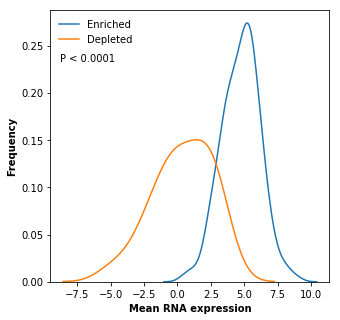

In [35]:
plot_df = df_go_cc.copy()
plot_df['Mean'] = plot_df.index.map(go_mean)
enriched_mean = plot_df[lambda x: x.Pval_in_study < mtc_pval]['Mean'].dropna()
depleted_mean = plot_df[lambda x: x.Pval_out_study < mtc_pval]['Mean'].dropna()

fig = plt.figure(figsize=[5,5])
plot = sns.distplot(enriched_mean, label='Enriched', hist=False)
plot = sns.distplot(depleted_mean, label='Depleted', hist=False)
print(scipy.stats.mannwhitneyu(depleted_mean, enriched_mean))
plot.set_xlabel('Mean RNA expression', weight='bold')
plot.set_ylabel('Frequency', weight='bold')
plot.text(0.035,0.81, 'P < 0.0001', transform = plot.transAxes)
plt.legend(frameon=False)
plt.savefig('Revisions/revision_figure_distribution_mean_rna_exp_GO.pdf', dpi=500, bbox_inches='tight')
plt.savefig('Revisions/revision_figure_distribution_mean_rna_exp_GO.png', dpi=500, bbox_inches='tight')
plt.show()